## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

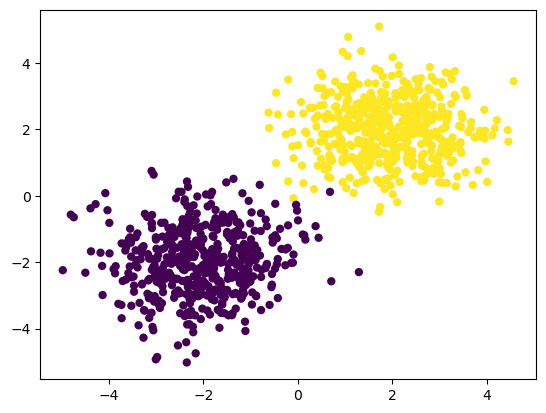

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

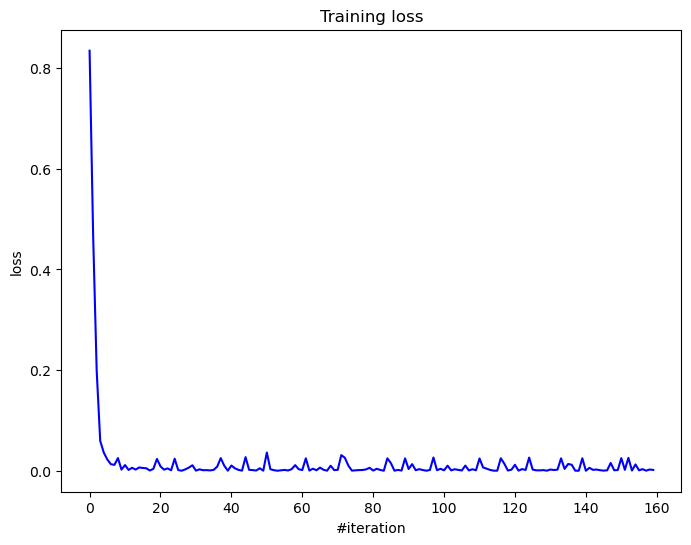

Current loss: 0.001652


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [8]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

In [9]:
# pip install python-mnist

In [10]:
# import mnist
# X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [11]:
import numpy as np
import struct
from array import array


def read_images_labels(images_filepath, labels_filepath):        
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())        
    
    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())        
    images = []
    for i in range(size):
        images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        images[i][:] = img

    images = np.array(image_data, dtype=np.uint8).reshape(size, rows, cols)            
    
    return images, labels


train_images, train_labels = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_images, test_labels = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

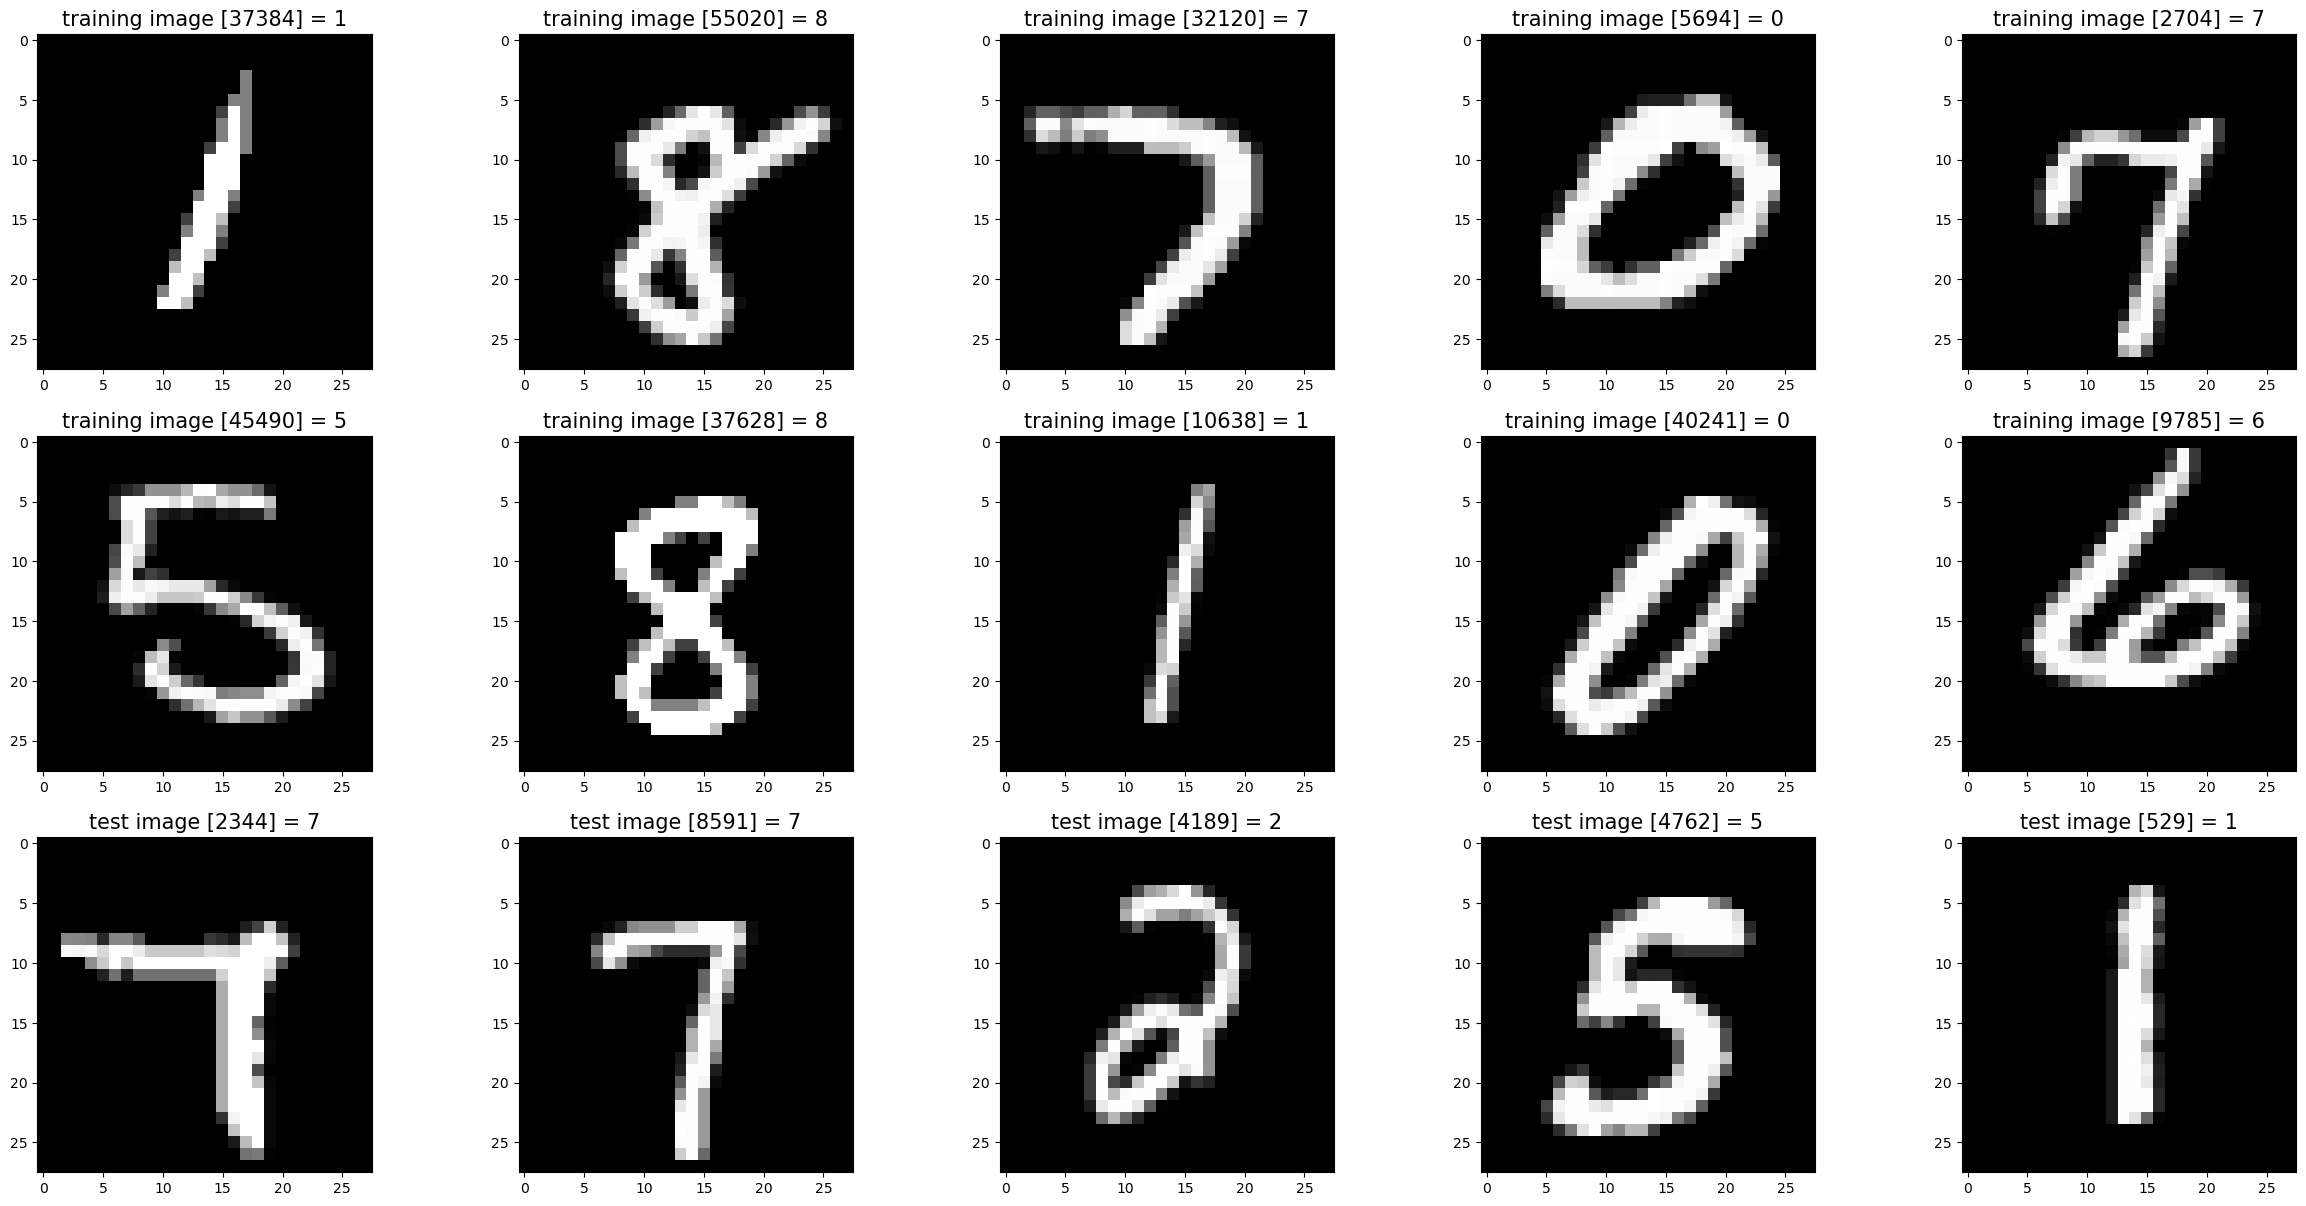

In [12]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1


images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(train_images[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(train_labels[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(test_images[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(test_labels[r]))    

show_images(images_2_show, titles_2_show)


One-hot encode the labels first.

In [13]:
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels_one_hot = one_hot_encode(train_labels)
test_labels_one_hot = one_hot_encode(test_labels)

train_images = train_images.reshape(-1, 784).astype('float32') / 255.0
test_images = test_images.reshape(-1, 784).astype('float32') / 255.0



- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [14]:
def create_model(ActivationFunction):
    net = Sequential()
    net.add(Linear(784, 128)) 
    net.add(ActivationFunction())  
    net.add(Linear(128, 32))
    net.add(ActivationFunction())
    net.add(Linear(32, 10))
    net.add(LogSoftMax())
    return net

def create_network_with_bn(ActivationFunction):
    net = Sequential()
    net.add(Linear(784, 128))
    net.add(BatchNormalization(128))
    net.add(ChannelwiseScaling(128)) 
    net.add(ActivationFunction())  
    net.add(Linear(128, 32))
    net.add(BatchNormalization(32))
    net.add(ChannelwiseScaling(32))
    net.add(ActivationFunction())
    net.add(Linear(32, 10))
    net.add(LogSoftMax())
    return net

def train_model(model, X, Y, criterion, optimizer='sgd', n_epochs=10):
    loss_history = []
    optimizer_state.clear()
    for epoch in range(n_epochs):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            # Forward
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)       
      

            # Backward
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)
            
            # Optimize
            if optimizer == 'sgd':
                sgd_momentum(model.getParameters(), 
                            model.getGradParameters(), 
                            optimizer_config,
                            optimizer_state)
            else:
                adam_optimizer(model.getParameters(),
                             model.getGradParameters(), 
                             optimizer_config,
                             optimizer_state)    
            
        loss_history.append(loss)


    return loss_history


In [ ]:
# оptimizer params
optimizer_config = {'learning_rate' : 1e-6, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 40
batch_size = 128

criterion = ClassNLLCriterion()

models = {
    'ReLU': create_model(ReLU),
    'ELU': create_model(ELU), 
    'LeakyReLU': create_model(LeakyReLU),
    'SoftPlus': create_model(SoftPlus),
    'ReLU_bn': create_network_with_bn(ReLU),
    'ELU_bn': create_network_with_bn(ELU), 
    'LeakyReLU_bn': create_network_with_bn(LeakyReLU),
    'SoftPlus_bn': create_network_with_bn(SoftPlus)
        }

Training ReLU model...
Training ELU model...
Training LeakyReLU model...
Training SoftPlus model...
Training ReLU_bn model...


C:\Users\Artem\AppData\Local\Temp\ipykernel_3776\1372144325.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * batch_mean
C:\Users\Artem\AppData\Local\Temp\ipykernel_3776\1372144325.py:23: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * batch_variance


Training ELU_bn model...
Training LeakyReLU_bn model...
Training SoftPlus_bn model...


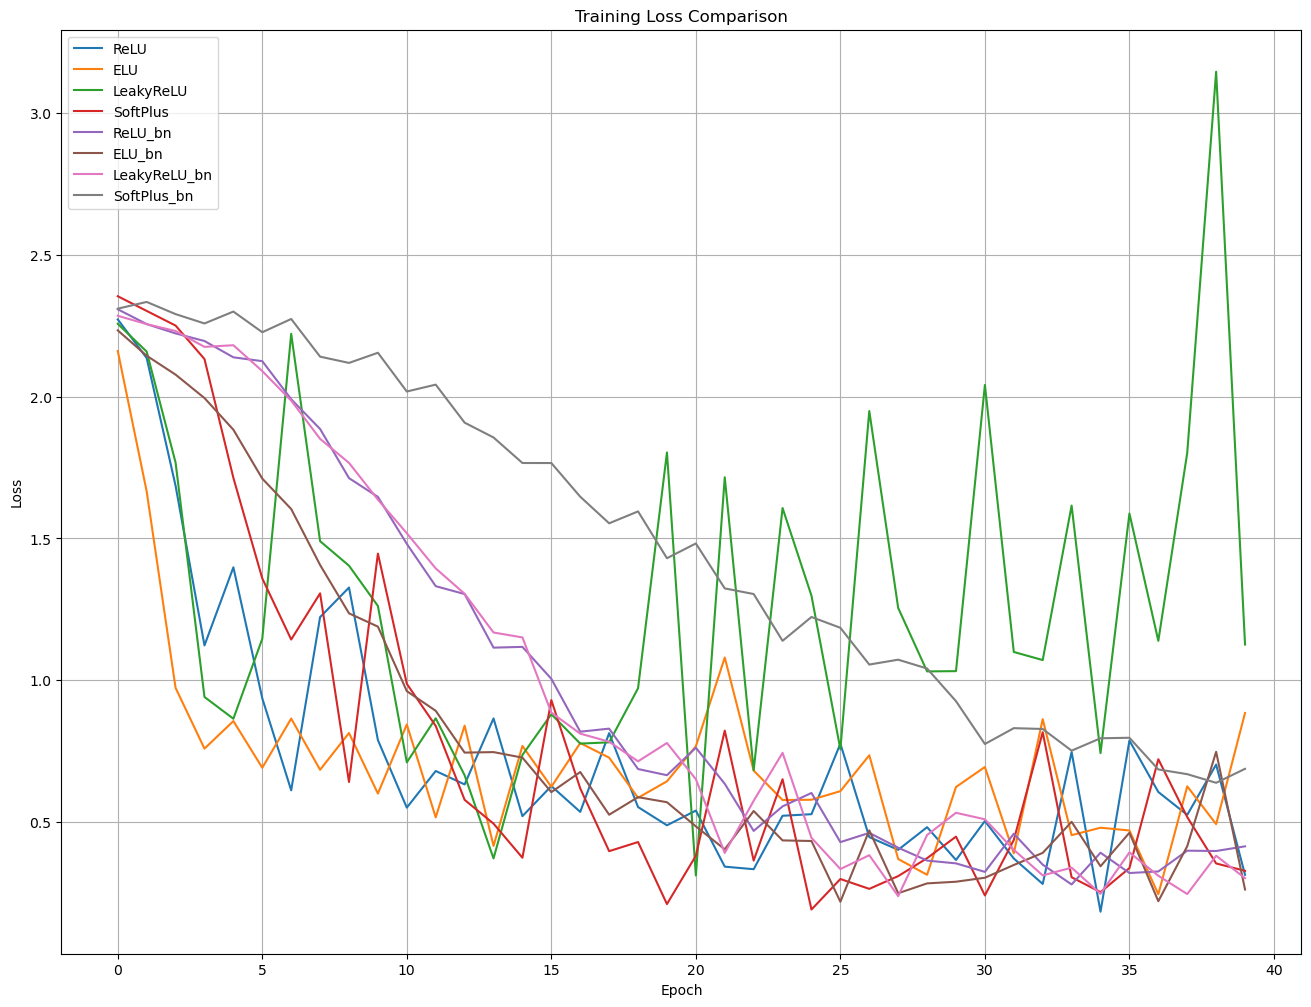


Final loss values:
ReLU: 0.3142
ELU: 0.8845
LeakyReLU: 1.1259
SoftPlus: 0.3282
ReLU_bn: 0.4145
ELU_bn: 0.2623
LeakyReLU_bn: 0.3024
SoftPlus_bn: 0.6877


In [16]:

histories = {}

for name, model in models.items():
    print(f"Training {name} model...")
    history = train_model(model, train_images, train_labels_one_hot, 
                         criterion, 'sgd', n_epoch)
    histories[name] = history

plt.figure(figsize=(16, 12))
for name, history in histories.items():
    plt.plot(history, label=name)

plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


print("\nFinal loss values:")
for name, history in histories.items():
    print(f"{name}: {history[-1]:.4f}")

In [30]:
optimizer_config_sgd = {'learning_rate': 1e-6, 'momentum': 0.9}
optimizer_config_adam = {'learning_rate': 1e-5, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}

optimizer_state_sgd = {}
optimizer_state_adam = {}

def train_model(model, X, Y, criterion, optimizer='sgd', n_epochs=10):
    loss_history = []
    if optimizer == 'sgd':
        config = optimizer_config_sgd
        state = optimizer_state_sgd
    elif optimizer == 'adam':
        config = optimizer_config_adam
        state = optimizer_state_adam
    else:
        raise ValueError("Unsupported optimizer")
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            # Forward
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)       

            # Backward
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)
            
            # Optimize
            if optimizer == 'sgd':
                sgd_momentum(model.getParameters(), 
                            model.getGradParameters(), 
                            config,
                            state)
            elif optimizer == 'adam':
                adam_optimizer(model.getParameters(),
                             model.getGradParameters(), 
                             config,
                             state)    
            
            epoch_loss += loss

        average_loss = epoch_loss / (len(X) / batch_size)
        loss_history.append(average_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {average_loss:.4f}")

    return loss_history



In [31]:
model_sgd = create_model(ReLU)
model_adam = create_model(ReLU)


In [32]:
print("Training with Momentum SGD...")
history_sgd = train_model(model_sgd, train_images, train_labels_one_hot, 
                          criterion, 'sgd', n_epoch)

print("\nTraining with Adam Optimizer...")
history_adam = train_model(model_adam, train_images, train_labels_one_hot, 
                           criterion, 'adam', n_epoch)

Training with Momentum SGD...
Epoch 1/40, Loss: 2.2913
Epoch 2/40, Loss: 2.2324
Epoch 3/40, Loss: 2.0349
Epoch 4/40, Loss: 1.4695
Epoch 5/40, Loss: 0.8857
Epoch 6/40, Loss: 0.8739
Epoch 7/40, Loss: 1.1459
Epoch 8/40, Loss: 1.6100
Epoch 9/40, Loss: 1.8044
Epoch 10/40, Loss: 1.1753
Epoch 11/40, Loss: 1.0780
Epoch 12/40, Loss: 0.8076
Epoch 13/40, Loss: 0.7471
Epoch 14/40, Loss: 0.6931
Epoch 15/40, Loss: 0.6185
Epoch 16/40, Loss: 0.6088
Epoch 17/40, Loss: 0.5612
Epoch 18/40, Loss: 0.5391
Epoch 19/40, Loss: 0.5496
Epoch 20/40, Loss: 0.5267
Epoch 21/40, Loss: 0.4928
Epoch 22/40, Loss: 0.5239
Epoch 23/40, Loss: 0.4944
Epoch 24/40, Loss: 0.5062
Epoch 25/40, Loss: 0.4789
Epoch 26/40, Loss: 0.4505
Epoch 27/40, Loss: 0.4511
Epoch 28/40, Loss: 0.4477
Epoch 29/40, Loss: 0.4594
Epoch 30/40, Loss: 0.4594
Epoch 31/40, Loss: 0.4556
Epoch 32/40, Loss: 0.4520
Epoch 33/40, Loss: 0.4607
Epoch 34/40, Loss: 0.4468
Epoch 35/40, Loss: 0.4454
Epoch 36/40, Loss: 0.4407
Epoch 37/40, Loss: 0.4102
Epoch 38/40, Loss

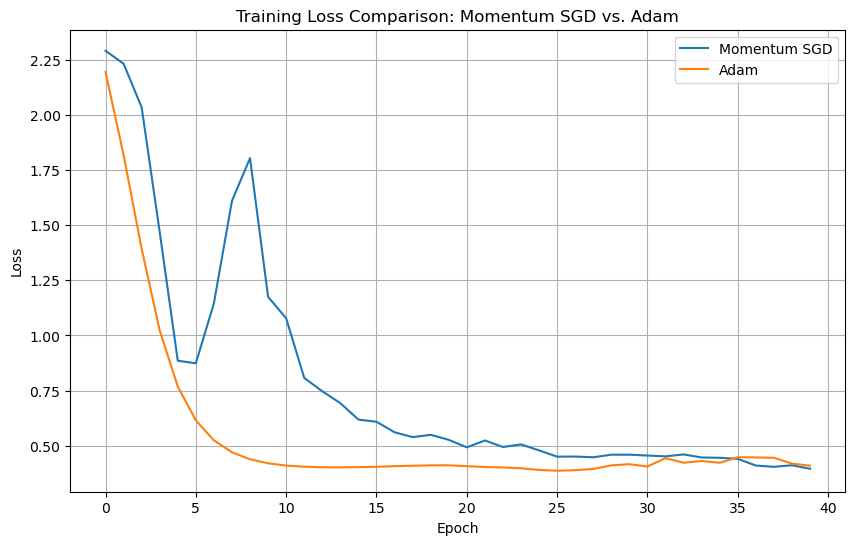


Final loss values:
Momentum SGD: 0.3955
Adam: 0.4096


In [33]:
plt.figure(figsize=(10, 6))
plt.plot(history_sgd, label='Momentum SGD')
plt.plot(history_adam, label='Adam')
plt.title("Training Loss Comparison: Momentum SGD vs. Adam")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

print("\nFinal loss values:")
print(f"Momentum SGD: {history_sgd[-1]:.4f}")
print(f"Adam: {history_adam[-1]:.4f}")

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [34]:
from scipy.ndimage import rotate, shift

def augment_data(images, labels, num_augmentations=5):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        for _ in range(num_augmentations):
            # Reshape to 28x28
            img_reshaped = img.reshape(28, 28)
            # Apply random rotation between -15 and 15 degrees
            angle = random.uniform(-15, 15)
            rotated_img = rotate(img_reshaped, angle, reshape=False, mode='nearest')

            # Apply random shift
            shift_x = random.uniform(-2, 2)
            shift_y = random.uniform(-2, 2)
            shifted_img = shift(rotated_img, shift=(shift_x, shift_y), mode='nearest')

            # Flatten back
            augmented_images.append(shifted_img.flatten())
            augmented_labels.append(label)
    return np.array(augmented_images, dtype=np.uint8), np.array(augmented_labels, dtype=np.uint8)

# Augment the training data
aug_images, aug_labels = augment_data(train_images, train_labels, num_augmentations=5)

# Combine original and augmented data
train_images_aug = np.vstack((train_images, aug_images))
train_labels_aug = np.hstack((train_labels, aug_labels))

print(f"Original training set size: {train_images.shape[0]}")
print(f"Augmented training set size: {train_images_aug.shape[0]}")

Original training set size: 60000
Augmented training set size: 360000


In [35]:
train_labels_aug_one_hot = one_hot_encode(train_labels_aug)

In [38]:
def enhanced_train_model(model, X, Y, criterion, optimizer='adam', n_epochs=20, initial_lr=1e-3, decay_rate=0.95, batch_size=128):
    loss_history = []
    if optimizer == 'sgd':
        config = {'learning_rate': initial_lr, 'momentum': 0.9}
        state = {}
    elif optimizer == 'adam':
        config = optimizer_config_adam.copy()
        state = optimizer_state_adam.copy()
    else:
        raise ValueError("Unsupported optimizer")
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        # Update learning rate
        config['learning_rate'] = initial_lr * (decay_rate ** epoch)
        
        # Set model to training mode
        model.train()

        for x_batch, y_batch in get_batches((X, Y), batch_size):

            # Forward
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)       

            # Backward
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)
            
            # Optimize
            if optimizer == 'sgd':
                sgd_momentum(model.getParameters(), 
                            model.getGradParameters(), 
                            config,
                            state)
            elif optimizer == 'adam':
                adam_optimizer(model.getParameters(),
                             model.getGradParameters(), 
                             config,
                             state)    
            
            epoch_loss += loss

        average_loss = epoch_loss / (len(X) / batch_size)
        loss_history.append(average_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {average_loss:.4f}, LR: {config['learning_rate']:.6f}")

    return loss_history


In [39]:
def create_enhanced_model(ActivationFunction, dropout_rate=0.5):
    net = Sequential()
    net.add(Linear(784, 256)) 
    net.add(BatchNormalization(256))
    net.add(Dropout(dropout_rate))
    net.add(ActivationFunction())  
    net.add(Linear(256, 128))
    net.add(BatchNormalization(128))
    net.add(Dropout(dropout_rate))
    net.add(ActivationFunction())
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    return net

In [ ]:
enhanced_model = create_enhanced_model(ReLU, dropout_rate=0.5)
optimizer_config_adam = {'learning_rate': 1e-5, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
optimizer_state_adam = {}

In [52]:
print("Training Enhanced Model with Adam Optimizer...")
history_enhanced = enhanced_train_model(enhanced_model, train_images_aug, train_labels_aug_one_hot, 
                                                 criterion, optimizer='adam', n_epochs=20, initial_lr=1e-5, decay_rate=0.95, batch_size=128)

Training Enhanced Model with Adam Optimizer...
Epoch 1/20, Loss: 1.6410, LR: 0.000010
Epoch 2/20, Loss: 1.5732, LR: 0.000010
Epoch 3/20, Loss: 1.5434, LR: 0.000009
Epoch 4/20, Loss: 1.5192, LR: 0.000009
Epoch 5/20, Loss: 1.4882, LR: 0.000008
Epoch 6/20, Loss: 1.4695, LR: 0.000008
Epoch 7/20, Loss: 1.4386, LR: 0.000007
Epoch 8/20, Loss: 1.4247, LR: 0.000007
Epoch 9/20, Loss: 1.4147, LR: 0.000007
Epoch 10/20, Loss: 1.3856, LR: 0.000006
Epoch 11/20, Loss: 1.3763, LR: 0.000006
Epoch 12/20, Loss: 1.3572, LR: 0.000006
Epoch 13/20, Loss: 1.3495, LR: 0.000005
Epoch 14/20, Loss: 1.3276, LR: 0.000005
Epoch 15/20, Loss: 1.3229, LR: 0.000005
Epoch 16/20, Loss: 1.3164, LR: 0.000005
Epoch 17/20, Loss: 1.2995, LR: 0.000004
Epoch 18/20, Loss: 1.3022, LR: 0.000004
Epoch 19/20, Loss: 1.2881, LR: 0.000004
Epoch 20/20, Loss: 1.2864, LR: 0.000004


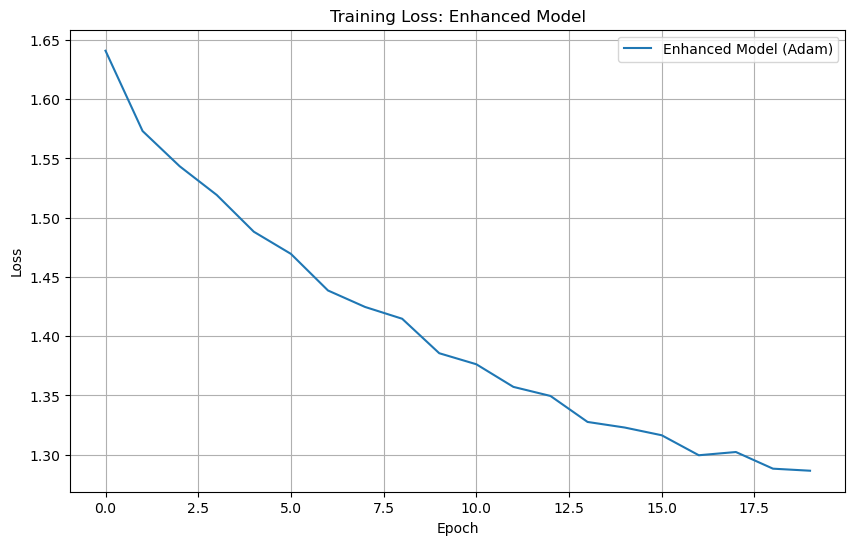

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(history_enhanced, label='Enhanced Model (Adam)')
plt.title("Training Loss: Enhanced Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [56]:
def evaluate_model(model, X, Y, batch_size=128):

    correct = 0
    total = 0
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        predictions = model.forward(x_batch)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(y_batch, axis=1)
        correct += np.sum(predicted_labels == true_labels)
        total += y_batch.shape[0]
    accuracy = correct / total
    return accuracy

# Evaluate on test set
test_accuracy = evaluate_model(enhanced_model, test_images, test_labels_one_hot)
print(f"Test Accuracy of Enhanced Model: {test_accuracy * 100:.2f}%")

Test Accuracy of Enhanced Model: 88.29%


In [19]:
# Your answer goes here. ################################################

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

In [58]:
# Define transformations: including data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]))

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:06<00:00, 1459089.06it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 41301.15it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 763265.58it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1135853.13it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [59]:
class EnhancedMNISTModel(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(EnhancedMNISTModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [60]:
model_pt = EnhancedMNISTModel(dropout_rate=0.5)

criterion_pt = nn.NLLLoss()
optimizer_pt = optim.Adam(model_pt.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer_pt, gamma=0.95)

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pt.to(device)

# Training loop
n_epochs = 20
for epoch in range(n_epochs):
    model_pt.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer_pt.zero_grad()
        
        # Forward + backward + optimize
        outputs = model_pt(images)
        loss = criterion_pt(outputs, labels)
        loss.backward()
        optimizer_pt.step()
        
        running_loss += loss.item() * images.size(0)
    
    # Update learning rate
    scheduler.step()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

Epoch 1/20, Loss: 0.9470, LR: 0.000950
Epoch 2/20, Loss: 0.5699, LR: 0.000902
Epoch 3/20, Loss: 0.4833, LR: 0.000857
Epoch 4/20, Loss: 0.4351, LR: 0.000815
Epoch 5/20, Loss: 0.4049, LR: 0.000774
Epoch 6/20, Loss: 0.3833, LR: 0.000735
Epoch 7/20, Loss: 0.3652, LR: 0.000698
Epoch 8/20, Loss: 0.3423, LR: 0.000663
Epoch 9/20, Loss: 0.3339, LR: 0.000630
Epoch 10/20, Loss: 0.3226, LR: 0.000599
Epoch 11/20, Loss: 0.3177, LR: 0.000569
Epoch 12/20, Loss: 0.3082, LR: 0.000540
Epoch 13/20, Loss: 0.3014, LR: 0.000513
Epoch 14/20, Loss: 0.3000, LR: 0.000488
Epoch 15/20, Loss: 0.2869, LR: 0.000463
Epoch 16/20, Loss: 0.2885, LR: 0.000440
Epoch 17/20, Loss: 0.2791, LR: 0.000418
Epoch 18/20, Loss: 0.2803, LR: 0.000397
Epoch 19/20, Loss: 0.2795, LR: 0.000377
Epoch 20/20, Loss: 0.2702, LR: 0.000358


In [63]:
model_pt.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)  
       
        outputs = model_pt(images)
        
        
        _, predicted = torch.max(outputs, 1) 
        
        
        correct += (predicted == labels).sum().item()
        
        
        total += labels.size(0)


accuracy = correct / total

print(f'Accuracy of the model on the test dataset: {accuracy * 100:.2f}%')

Accuracy of the model on the test dataset: 97.95%
